In [1]:
# ## 1. Importação de Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


=== INFORMAÇÕES INICIAIS DO DATASET ===
Dimensões originais: (569, 30) features, (569, 1) targets
Distribuição das classes: Maligno=212, Benigno=357
Proporção: 37.26% maligno vs 62.74% benigno

=== DADOS APÓS PRÉ-PROCESSAMENTO ===
Dados após PCA (2D):
 - Treino: (455, 2) features
   Distribuição classes: Maligno=170, Benigno=285
 - Teste: (114, 2) features
   Distribuição classes: Maligno=42, Benigno=72


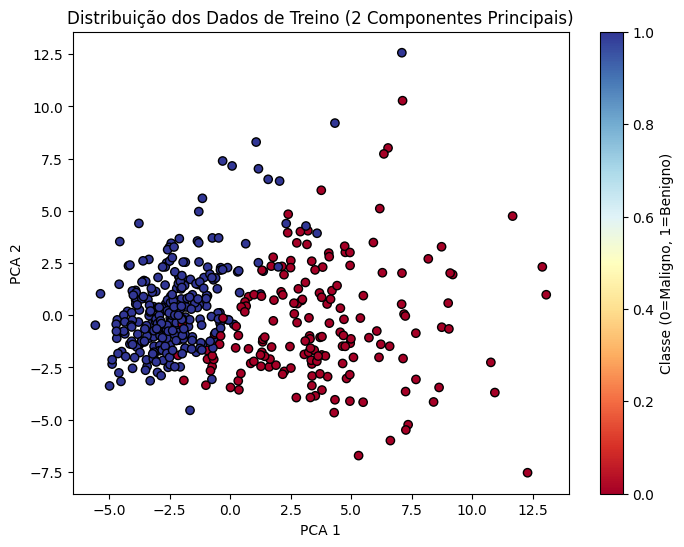

In [2]:
# ## 2. Carregamento e Pré-processamento dos Dados
data = load_breast_cancer()  # Carrega o conjunto de dados de câncer de mama

X = data.data  # Atribui as features (atributos) a X
y = data.target.reshape(-1, 1)  # Ajusta o vetor de rótulos y

print("\n=== INFORMAÇÕES INICIAIS DO DATASET ===")
print(f"Dimensões originais: {X.shape} features, {y.shape} targets")  # Mostra a forma dos dados
print(f"Distribuição das classes: Maligno={np.sum(y==0)}, Benigno={np.sum(y==1)}")  # Mostra quantos exemplos de cada classe
print(f"Proporção: {np.sum(y==0)/len(y):.2%} maligno vs {np.sum(y==1)/len(y):.2%} benigno")  # Mostra a proporção entre classes

scaler = StandardScaler()  # Cria objeto para normalização dos dados
X_scaled = scaler.fit_transform(X)  # Aplica normalização (zero média, unidade de desvio)

pca = PCA(n_components=2)  # Cria o objeto PCA (Análise de Componentes Principais) para reduzir os dados a 2 componentes
X_pca = pca.fit_transform(X_scaled)  # Aplica PCA nos dados normalizados

X_train, X_test, y_train, y_test = train_test_split(  # Divide os dados em treino e teste
    X_pca, y, test_size=0.2, random_state=42, stratify=y  # Usa 20% para teste e mantém a proporção das classes
)

print("\n=== DADOS APÓS PRÉ-PROCESSAMENTO ===")
print(f"Dados após PCA (2D):")
print(f" - Treino: {X_train.shape} features")
print(f"   Distribuição classes: Maligno={np.sum(y_train==0)}, Benigno={np.sum(y_train==1)}")
print(f" - Teste: {X_test.shape} features")
print(f"   Distribuição classes: Maligno={np.sum(y_test==0)}, Benigno={np.sum(y_test==1)}")

plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), cmap=plt.cm.RdYlBu, edgecolors='k')
plt.title("Distribuição dos Dados de Treino (2 Componentes Principais)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Classe (0=Maligno, 1=Benigno)")
plt.show()

In [3]:
# ## 3. Inicialização da Rede Neural
input_size = X_train.shape[1]  # Define número de entradas com base nas features (2)
hidden_size = 4  # Número de neurônios na camada oculta
output_size = 1  # Um único neurônio de saída para classificação binária

np.random.seed(42)  # Fixa semente aleatória para reprodutibilidade

# Inicializa pesos e bias com valores aleatórios pequenos (multiplicado por 0.1 para que não inicie com valores muito grandes)
W1 = np.random.randn(input_size, hidden_size) * 0.1  # Pesos da entrada para camada oculta
b1 = np.random.randn(1, hidden_size) * 0.1  # Bias da camada oculta
W2 = np.random.randn(hidden_size, output_size) * 0.1  # Pesos da camada oculta para saída
b2 = np.random.randn(1, output_size) * 0.1  # Bias da camada de saída

print("\n=== ARQUITETURA DA REDE ===")
print(f"Configuração: {input_size} -> {hidden_size} -> {output_size}")  # Mostra arquitetura
print("Pesos iniciais:")
print(f"W1 shape: {W1.shape}, valores:\n{W1}")
print(f"b1 shape: {b1.shape}, valores:\n{b1}")
print(f"W2 shape: {W2.shape}, valores:\n{W2}")
print(f"b2 shape: {b2.shape}, valores:\n{b2}")


=== ARQUITETURA DA REDE ===
Configuração: 2 -> 4 -> 1
Pesos iniciais:
W1 shape: (2, 4), valores:
[[ 0.04967142 -0.01382643  0.06476885  0.15230299]
 [-0.02341534 -0.0234137   0.15792128  0.07674347]]
b1 shape: (1, 4), valores:
[[-0.04694744  0.054256   -0.04634177 -0.04657298]]
W2 shape: (4, 1), valores:
[[ 0.02419623]
 [-0.19132802]
 [-0.17249178]
 [-0.05622875]]
b2 shape: (1, 1), valores:
[[-0.10128311]]


In [4]:
# ## 4. Definição das Funções da Rede
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def forward_prop(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1  # Soma ponderada da camada oculta
    a1 = tanh(z1)
    z2 = np.dot(a1, W2) + b2  # Soma ponderada da saída
    a2 = sigmoid(z2)
    return a2, a1, z1, z2  # Retorna ativações e somas ponderadas para uso no backprop

def backward_prop(X, y, a2, a1, z1, W2):
    m = X.shape[0]  # Número de amostras
    dz2 = a2 - y
    dW2 = (1/m) * np.dot(a1.T, dz2)
    db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)
    dz1 = np.dot(dz2, W2.T) * (1 - np.power(np.tanh(z1), 2))
    dW1 = (1/m) * np.dot(X.T, dz1)
    db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)
    return dW1, db1, dW2, db2

def compute_loss(y_true, y_pred):  # Função de custo (cross-entropy)
    epsilon = 1e-15  # Para evitar log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Garante que y_pred esteja dentro de (0,1)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))  # Fórmula da perda

def mostrar_matriz_confusao(y_true, y_pred, titulo="Matriz de Confusão"):
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== {titulo} ===")
    print(cm)
    print("Legenda: [ [Verdadeiro Negativo, Falso Positivo], [Falso Negativo, Verdadeiro Positivo] ]")


In [18]:
# ## 5. Treinamento com Batch Learning
print("\n=== TREINAMENTO BATCH LEARNING ===")
def train_batch(X, y, W1, b1, W2, b2, learning_rate=0.1, epochs=50, print_every=5):  # Treinamento em batch
    losses = []  # Armazena perdas
    accuracies = []  # Armazena acurácias

    print(f"Configuração: LR={learning_rate}, Epochs={epochs}, Batch Size=Todos ({X.shape[0]} amostras)")
    print("--------------------------------------------------")

    for epoch in range(epochs): # Laço de épocas
        a2, a1, z1, z2 = forward_prop(X, W1, b1, W2, b2)
        loss = compute_loss(y, a2)  # Cálculo da perda
        acc = accuracy_score(y, (a2 > 0.5).astype(int))  # Cálculo da acurácia
        losses.append(loss)  # Armazena perda
        accuracies.append(acc)  # Armazena acurácia
        dW1, db1, dW2, db2 = backward_prop(X, y, a2, a1, z1, W2)
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        if epoch % print_every == 0 or epoch == epochs - 1:  # Exibe progresso periodicamente
            print(f"Época {epoch+1:2d}/{epochs} | Perda: {loss:.4f} | Acurácia: {acc:.4f}")

    print("--------------------------------------------------")
    print("Treinamento Batch Learning concluído!")
    return W1, b1, W2, b2, losses, accuracies  # Retorna pesos e métricas

epochs_batch = 50  # Número de épocas para treinamento batch
lr_batch = 0.1  # Taxa de aprendizado
W1_batch, b1_batch, W2_batch, b2_batch, losses_batch, accs_batch = train_batch(  # Executa treinamento batch
    X_train, y_train, W1.copy(), b1.copy(), W2.copy(), b2.copy(),
    learning_rate=lr_batch, epochs=epochs_batch
)

# Avaliação do modelo treinado com Batch Learning
y_pred_batch = forward_prop(X_test, W1_batch, b1_batch, W2_batch, b2_batch)[0]
y_pred_batch_class = (y_pred_batch > 0.5).astype(int)

mostrar_matriz_confusao(y_test, y_pred_batch_class, titulo="Batch Learning (Teste)")




=== TREINAMENTO BATCH LEARNING ===
Configuração: LR=0.1, Epochs=50, Batch Size=Todos (455 amostras)
--------------------------------------------------
Época  1/50 | Perda: 0.6938 | Acurácia: 0.3978
Época  6/50 | Perda: 0.6091 | Acurácia: 0.8725
Época 11/50 | Perda: 0.5221 | Acurácia: 0.9099
Época 16/50 | Perda: 0.4412 | Acurácia: 0.9231
Época 21/50 | Perda: 0.3754 | Acurácia: 0.9341
Época 26/50 | Perda: 0.3249 | Acurácia: 0.9407
Época 31/50 | Perda: 0.2868 | Acurácia: 0.9407
Época 36/50 | Perda: 0.2577 | Acurácia: 0.9451
Época 41/50 | Perda: 0.2353 | Acurácia: 0.9451
Época 46/50 | Perda: 0.2176 | Acurácia: 0.9473
Época 50/50 | Perda: 0.2061 | Acurácia: 0.9451
--------------------------------------------------
Treinamento Batch Learning concluído!

=== Batch Learning (Teste) ===
[[38  4]
 [ 2 70]]
Legenda: [ [Verdadeiro Negativo, Falso Positivo], [Falso Negativo, Verdadeiro Positivo] ]


In [19]:
# ## 6. Treinamento com Online Learning
print("\n=== TREINAMENTO ONLINE LEARNING ===")
def train_online(X, y, W1, b1, W2, b2, learning_rate=0.01, epochs=50):  # Treinamento online (amostra por amostra)
    losses = []
    accuracies = []

    print(f"Configuração: LR={learning_rate}, Epochs={epochs}, Batch Size=1 (amostra por amostra)")
    print("--------------------------------------------------")

    for epoch in range(epochs):  # Laço de épocas
        epoch_loss = 0 #acumulador da perda durante a época.

        for i in range(X.shape[0]):  # Para cada amostra
            xi, yi = X[i:i+1], y[i:i+1]  # Seleciona uma amostra
            a2, a1, z1, z2 = forward_prop(xi, W1, b1, W2, b2)  # Forward
            loss = compute_loss(yi, a2) # Calcula a função de perda (loss) entre a saída da rede e o rótulo verdadeiro yi
            epoch_loss += loss
            dW1, db1, dW2, db2 = backward_prop(xi, yi, a2, a1, z1, W2)  # Backprop
            W1 -= learning_rate * dW1  # Atualiza pesos
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2

        avg_loss = epoch_loss / X.shape[0]  # Calcula a perda média da época.
        losses.append(avg_loss)
        a2_all = forward_prop(X, W1, b1, W2, b2)[0]  # Predição em todo o conjunto
        acc = accuracy_score(y, (a2_all > 0.5).astype(int))  # Acurácia
        accuracies.append(acc)
        print(f"Época {epoch+1:2d}/{epochs} | Perda: {avg_loss:.4f} | Acurácia: {acc:.4f}")

    print("--------------------------------------------------")
    print("Treinamento Online Learning concluído!")
    return W1, b1, W2, b2, losses, accuracies  # Retorna pesos e métricas

epochs_online = 50  # Número de épocas para online learning
lr_online = 0.1  # Taxa de aprendizado para online

W1_online, b1_online, W2_online, b2_online, losses_online, accs_online = train_online(  # Executa treinamento online
    X_train, y_train, W1.copy(), b1.copy(), W2.copy(), b2.copy(),
    learning_rate=lr_online, epochs=epochs_online
)

# Avaliação do modelo treinado com Online Learning
y_pred_online = forward_prop(X_test, W1_online, b1_online, W2_online, b2_online)[0]
y_pred_online_class = (y_pred_online > 0.5).astype(int)

mostrar_matriz_confusao(y_test, y_pred_online_class, titulo="Online Learning (Teste)")



=== TREINAMENTO ONLINE LEARNING ===
Configuração: LR=0.1, Epochs=50, Batch Size=1 (amostra por amostra)
--------------------------------------------------
Época  1/50 | Perda: 0.1841 | Acurácia: 0.9516
Época  2/50 | Perda: 0.1384 | Acurácia: 0.9560
Época  3/50 | Perda: 0.1304 | Acurácia: 0.9560
Época  4/50 | Perda: 0.1352 | Acurácia: 0.9560
Época  5/50 | Perda: 0.1372 | Acurácia: 0.9582
Época  6/50 | Perda: 0.1359 | Acurácia: 0.9538
Época  7/50 | Perda: 0.1336 | Acurácia: 0.9516
Época  8/50 | Perda: 0.1373 | Acurácia: 0.9473
Época  9/50 | Perda: 0.1348 | Acurácia: 0.9560
Época 10/50 | Perda: 0.1336 | Acurácia: 0.9341
Época 11/50 | Perda: 0.1355 | Acurácia: 0.9582
Época 12/50 | Perda: 0.1352 | Acurácia: 0.9385
Época 13/50 | Perda: 0.1299 | Acurácia: 0.9451
Época 14/50 | Perda: 0.1317 | Acurácia: 0.9582
Época 15/50 | Perda: 0.1310 | Acurácia: 0.9604
Época 16/50 | Perda: 0.1303 | Acurácia: 0.9604
Época 17/50 | Perda: 0.1283 | Acurácia: 0.9604
Época 18/50 | Perda: 0.1274 | Acurácia: 0.958


=== COMPARAÇÃO DOS MÉTODOS ===


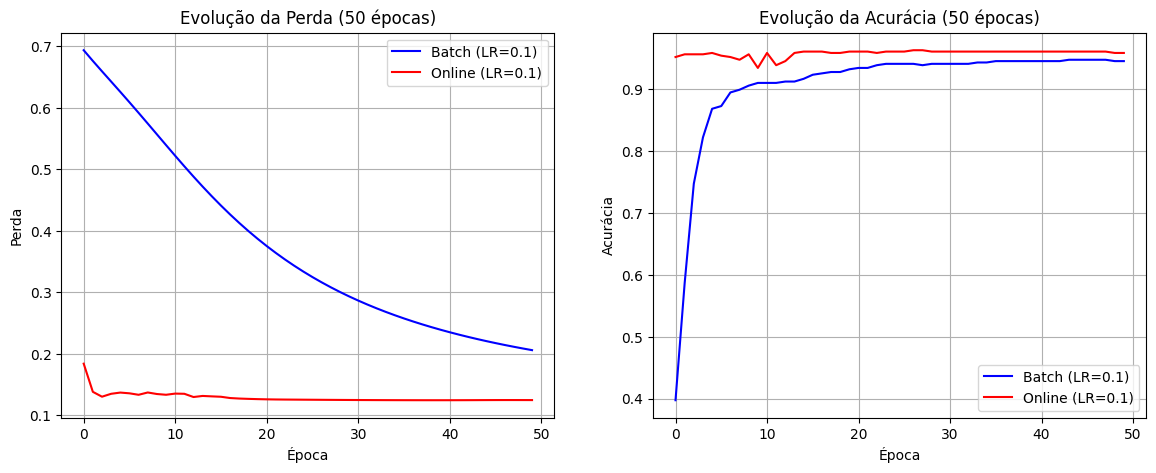

In [20]:
# ## 7. Comparação dos Métodos
print("\n=== COMPARAÇÃO DOS MÉTODOS ===")
plt.figure(figsize=(14, 5))

# Gráfico de Perdas
plt.subplot(1, 2, 1)  # Primeiro gráfico (à esquerda)
plt.plot(losses_batch, 'b-', label=f'Batch (LR={lr_batch})')
plt.plot(losses_online, 'r-', label=f'Online (LR={lr_online})')
plt.title(f"Evolução da Perda ({epochs_batch} épocas)")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.legend()
plt.grid(True)

# Gráfico de Acurácias
plt.subplot(1, 2, 2)
plt.plot(accs_batch, 'b-', label=f'Batch (LR={lr_batch})')
plt.plot(accs_online, 'r-', label=f'Online (LR={lr_online})')
plt.title(f"Evolução da Acurácia ({epochs_batch} épocas)")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)

In [21]:
# ## 8. Avaliação Final
print("\n=== AVALIAÇÃO FINAL ===")

def evaluate_model(X, y, W1, b1, W2, b2, model_name):
    y_pred = forward_prop(X, W1, b1, W2, b2)[0]
    train_acc = accuracy_score(y_train, (forward_prop(X_train, W1, b1, W2, b2)[0] > 0.5).astype(int))
    test_acc = accuracy_score(y, (y_pred > 0.5).astype(int))

    print(f"\n{model_name}:")
    print(f" - Acurácia no Treino: {train_acc*100:.2f}%")
    print(f" - Acurácia no Teste: {test_acc*100:.2f}%")

    return test_acc

# Avaliação dos modelos
print(f"\nResultados após {epochs_batch} épocas:")
test_acc_batch = evaluate_model(X_test, y_test, W1_batch, b1_batch, W2_batch, b2_batch, "Batch Learning")
test_acc_online = evaluate_model(X_test, y_test, W1_online, b1_online, W2_online, b2_online, "Online Learning")


=== AVALIAÇÃO FINAL ===

Resultados após 50 épocas:

Batch Learning:
 - Acurácia no Treino: 94.51%
 - Acurácia no Teste: 94.74%

Online Learning:
 - Acurácia no Treino: 95.82%
 - Acurácia no Teste: 92.98%



=== FRONTEIRAS DE DECISÃO ===


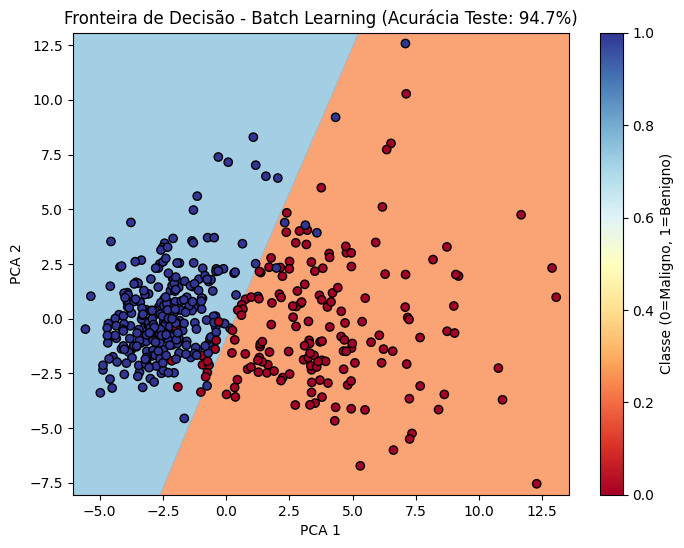

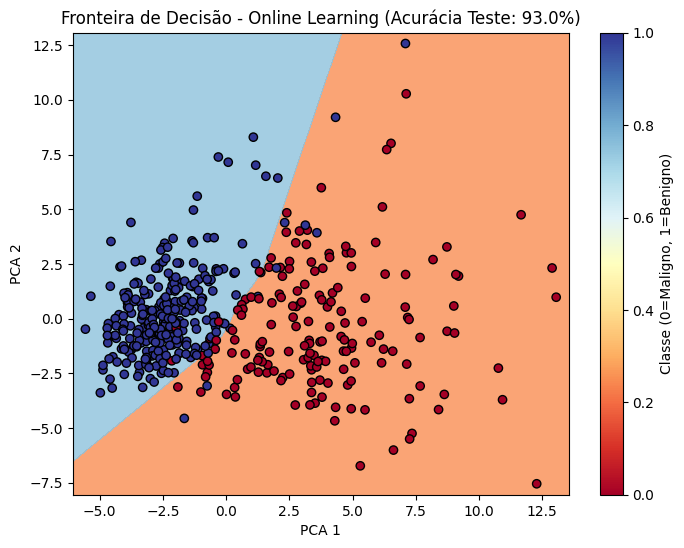

In [22]:
# ## 9. Visualização das Fronteiras de Decisão
print("\n=== FRONTEIRAS DE DECISÃO ===")

def plot_decision_boundary(X, y, W1, b1, W2, b2, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    a2 = forward_prop(grid, W1, b1, W2, b2)[0]
    Z = (a2 > 0.5).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(label="Classe (0=Maligno, 1=Benigno)")
    plt.show()

# Plot para Batch Learning
plot_decision_boundary(X_train, y_train, W1_batch, b1_batch, W2_batch, b2_batch,
                      f"Fronteira de Decisão - Batch Learning (Acurácia Teste: {test_acc_batch*100:.1f}%)")

# Plot para Online Learning
plot_decision_boundary(X_train, y_train, W1_online, b1_online, W2_online, b2_online,
                      f"Fronteira de Decisão - Online Learning (Acurácia Teste: {test_acc_online*100:.1f}%)")